# KAGGLE CIFAR-10

by [Dhanush Kamath](https://www.linkedin.com/in/dhanushkamath/) | [GitHub](https://www.github.com/dhanushkamath/) | B.Tech-III Electrical Engineering, National Institute of Technology, Surat, India

## Introduction and Prerequisites
This notebook explores different techniques for performing image classification on the popular CIFAR-10 dataset provided on Kaggle using Convolutional Neural Networks.

### Dataset and File Structure
Register and download all the data from the provided kaggle link :
[CIFAR 10 Dataset](https://www.kaggle.com/c/cifar-10/data)
<br/>The training data is to be unziped at the location : 'data/train' <br/>
The labels.csv file : 'data/trainLabels.csv'<br/>
The sample submission file : 'data/sampleSubmission.csv'

### Imports and some required definitions

In [1]:
import pandas as pd
from glob import glob
import keras
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.xception import Xception
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
from keras.layers import *
from keras.models import *
from keras.applications import *
from sklearn.manifold import TSNE
from keras.optimizers import *
from keras.regularizers import *
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
x_train = None
y_train = None
x_test = None
labels_path = 'data/trainLabels.csv'
sample_path = 'data/sampleSubmission.csv'
train_path = 'data/train/'
test_path = 'data/test/'

## Exploring and Preprocessing the Labels Dataframe

#### Loading Labels

In [3]:
labels = pd.read_csv(labels_path)
print("First few elements : ")
labels.head(5)

First few elements : 


,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


#### A high level overview of the dataframe

In [4]:
unique_labels = sorted(set(labels['label']))
n_class = len(unique_labels)
class_to_num = dict(zip(unique_labels, range(n_class)))
num_to_class = dict(zip(range(n_class), unique_labels))


print("Dimensions of the labels dataframe : ", labels.shape)
print('The',n_class,'different labels are :\n', unique_labels)
print('\nThe distribution of the classes are :\n', Counter(labels['label']))
# The output shows that the variable is equally distributed among the different 
# classes with each class having 5000 images. 

Dimensions of the labels dataframe :  (50000, 2)
The 10 different labels are :
 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

The distribution of the classes are :
 Counter({'cat': 5000, 'ship': 5000, 'truck': 5000, 'horse': 5000, 'airplane': 5000, 'deer': 5000, 'dog': 5000, 'bird': 5000, 'frog': 5000, 'automobile': 5000})


#### One hot encoding of the labels (for training the CNN)

In [5]:
id = labels['id']
encoded = pd.get_dummies(labels['label'])
print('\nThe new dimensions of the dataframe are :',encoded.shape,'\n\n')
encoded.head(4)


The new dimensions of the dataframe are : (50000, 10) 




,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0


#### Converting the one hot encoded labels dataframe into a numpy array

In [6]:
encoded = np.asarray(encoded)
id = np.asarray(id)
print('The dimensions of the one hot encoded labels numpy array are :',np.shape(encoded))
print('The dimensions of the id numpy array are :',np.shape(id))

The dimensions of the one hot encoded labels numpy array are : (50000, 10)
The dimensions of the id numpy array are : (50000,)


## Loading and Exploring the Training Data

### Loading the Training data


#### Defining some helper functions

In [35]:
def create_traindata(id=id,size=100):   
    x_train = []
    y_train = []
    for i in tqdm(id):
        img = cv2.imread('data/train/{}.png'.format(i))
        label = encoded[i-1]
        x_train.append(cv2.resize(img, (139, 139)))
        y_train.append(label)
    
    np.save('data/saved_npy/y_train.npy',y_train)
    np.save('data/saved_npy/x_train.npy',x_train)
    return x_train, y_train    

def load_traindata():
    if glob('data/saved_npy/*.npy'):
        y_train = np.load('data/saved_npy/y_train.npy')
        x_train = np.load('data/saved_npy/x_train.npy')
        print('Training data loaded from disk!')
    else: 
        print('No saved data found. Creating..')
        x_train, y_train = create_traindata()
    return x_train, y_train
    
def show_images():
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.6, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(x_train[i])
        
        # Name of the true class.
        cls_true_name = num_to_class[y_train[i].argmax()]
        xlabel = "class: {0}".format(cls_true_name)
        
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    return

#### Let's load and view the images and their corresponding labels to check if the code is correct using the helper function defined above.

In [10]:
x_train, y_train = load_traindata()
x_train = np.array(x_train)
y_train = np.array(y_train)

Training data loaded from disk!


In [11]:
np.shape(x_train)

(50000, 139, 139, 3)

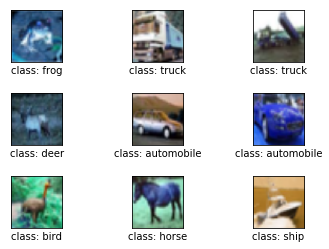

In [12]:
show_images()

## Training

### Obtaining Botteneck Features of Pretrained Xception

#### Defining some helper functions

In [7]:
def cnn_load_model(model='inceptionv3'):
    im_size=139
    if model == 'xception':
        cnn_model = Xception(include_top=False, input_shape=(im_size, im_size, 3), weights='imagenet')
    else:
        cnn_model = InceptionV3(include_top=False, input_shape=(im_size, im_size, 3), weights='imagenet')
    
    for layer in cnn_model.layers:
        layer.trainable = False
    
    inputs = Input((im_size, im_size, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)
    cnn_model.summary()
    return cnn_model


def bottleneck_features(model='inceptionv3'):
    print('Loading model:',model)
    if glob('data/saved_npy/'+model+'_features.npy'):
        features = np.load('data/saved_npy/'+model+'_features.npy')
        print('Features loaded from disk!')
    else:
        xception_m = cnn_load_model(model)
        features = xception_m.predict(x=x_train, batch_size=64, verbose=1)
        np.save('data/saved_npy/'+model+'_features.npy',features)
    return features

#### Otaining Inception Bottleneck features

In [8]:
features = np.asarray(bottleneck_features(model='inceptionv3'))

Loading model: inceptionv3
Features loaded from disk!


#### The dimensions of the Inception bottleneck features 

In [9]:
np.shape(features)

(50000, 2048)

#### Obtaining Xception Bottleneck features

In [11]:
features2 = np.asarray(bottleneck_features(model='xception'))

Loading model: xception
Features loaded from disk!


#### The dimensions of the Inception bottleneck features 

In [12]:
np.shape(features2)

(50000, 2048)

###  A Fully Connected Layer on Botteneck Features
#### Some Helper Functions

In [16]:
def fc_layer(features=features,y_train = y_train):
    if y_train is None:
        y_train = np.load('data/saved_npy/y_train.npy')
    
    num_class = 10
    inputs = Input(features.shape[1:])
    x = inputs
    x = Dense(256,activation = None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_class, activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    h = model.fit(features, y_train, batch_size=128,validation_split = 0.02, epochs=5,verbose=1)
    return model

def inception_from_disk(path = 'data/my_inceptionv3.h5'):
    if glob(path):
        fc_model = load_model(path)
        print('InceptionV3 Model Loaded from Disk!')
    else:
        fc_model = fc_layer(features)
        fc_model.save(path)
    return fc_model

def xception_from_disk(path = 'data/my_xception.h5'):
    if glob(path):
        fc_model = load_model(path)
        print('Xception Model Loaded from Disk!')
    else:
        fc_model = fc_layer(features2)
        fc_model.save(path)
    return fc_model

def concat_from_disk(path = 'data/concat.h5'):
    if glob(path):
        fc_model = load_model(path)
        print('Third Model Loaded from Disk!')
    else:
        fc_model = fc_layer(features3)
        fc_model.save(path)
    return fc_model

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_tsne(features = features):
    numbered = LabelEncoder().fit_transform(list(labels['label']))
    c = get_cmap(len(set(numbered)))
    colors=[]
    for num in numbered:
        temp=c(num)
        colors.append(temp)
        
    if glob('data/saved_npy/X_embedded.npy'):
        X_embedded = np.load('data/saved_npy/X_embedded.npy')
        print('Embedded Features loaded from Disk!')
    else:
        print('Fitting TSNE and saving to disk...')
        X_embedded = TSNE(n_components=2).fit_transform(features[:10000])
        X_embedded = np.array(X_embedded)
        np.save('data/saved_npy/X_embedded.npy', X_embedded)
    vis_x = X_embedded[:, 0]
    vis_y = X_embedded[:, 1]
    numbered = LabelEncoder().fit_transform(list(labels['label']))
    c = get_cmap(len(set(numbered)))
    plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(vis_x, vis_y, c=colors,alpha=1,linewidths=1,s=10, edgecolors='none')
    plt.show()
    return X_embedded

### Model 1 : InceptionV3
Inception v3 gives an accuracy of about <b>80%</b> using <b>hold out cross validation</b> with 1000 images for validation.

In [30]:
fc_model = inception_from_disk()

Train on 49000 samples, validate on 1000 samples
Epoch 1/5
49000/49000 [==============================] - 7s - loss: 0.7779 - acc: 0.7400 - val_loss: 0.6837 - val_acc: 0.7540
Epoch 2/5
49000/49000 [==============================] - 6s - loss: 0.5575 - acc: 0.8064 - val_loss: 0.5790 - val_acc: 0.7900
Epoch 3/5
49000/49000 [==============================] - 7s - loss: 0.4824 - acc: 0.8296 - val_loss: 0.6110 - val_acc: 0.8010
Epoch 4/5
49000/49000 [==============================] - 7s - loss: 0.4300 - acc: 0.8488 - val_loss: 0.6403 - val_acc: 0.7950
Epoch 5/5
49000/49000 [==============================] - 7s - loss: 0.3905 - acc: 0.8635 - val_loss: 0.6120 - val_acc: 0.7970


### Model 2 : Xception
Inception v3 gives an accuracy of about <b>84%</b> using <b>hold out cross validation</b> with 1000 images for validation.

In [32]:
fc_model2 = xception_from_disk()

Train on 49000 samples, validate on 1000 samples
Epoch 1/5
49000/49000 [==============================] - 7s - loss: 0.6815 - acc: 0.7764 - val_loss: 0.5397 - val_acc: 0.8230
Epoch 2/5
49000/49000 [==============================] - 6s - loss: 0.4811 - acc: 0.8331 - val_loss: 0.4989 - val_acc: 0.8360
Epoch 3/5
49000/49000 [==============================] - 7s - loss: 0.4084 - acc: 0.8568 - val_loss: 0.4931 - val_acc: 0.8390
Epoch 4/5
49000/49000 [==============================] - 7s - loss: 0.3592 - acc: 0.8743 - val_loss: 0.5165 - val_acc: 0.8280
Epoch 5/5
49000/49000 [==============================] - 7s - loss: 0.3168 - acc: 0.8878 - val_loss: 0.5041 - val_acc: 0.8380


### Model 3 : Concatenating Inception and Xception Features
This model gives an accuracy of about <b>85%</b> using <b>hold out cross validation</b> with 1000 images for validation.

In [13]:
features3 = np.concatenate([features, features2], axis=-1)

#### Dimensions of the resulting concatenated array

In [14]:
np.shape(features3)

(50000, 4096)

In [17]:
fc_model3 = concat_from_disk()

Train on 49000 samples, validate on 1000 samples
Epoch 1/5
49000/49000 [==============================] - 27s - loss: 0.6107 - acc: 0.7963 - val_loss: 0.4988 - val_acc: 0.8180 0.6226 - acc: 0. - ETA: 3s - loss: 0 - ETA: 0s - loss: 0.6114 - acc: 0.79
Epoch 2/5
49000/49000 [==============================] - 12s - loss: 0.4032 - acc: 0.8612 - val_loss: 0.4825 - val_acc: 0.8380
Epoch 3/5
49000/49000 [==============================] - 12s - loss: 0.3281 - acc: 0.8854 - val_loss: 0.4820 - val_acc: 0.8500
Epoch 4/5
49000/49000 [==============================] - 12s - loss: 0.2762 - acc: 0.9032 - val_loss: 0.4720 - val_acc: 0.8470
Epoch 5/5
49000/49000 [==============================] - 12s - loss: 0.2376 - acc: 0.9175 - val_loss: 0.5021 - val_acc: 0.8430


### Visualizing the Inception V3 bottleneck features using T-SNE dimensionality reduction
It is observed that the bottleneck features of different classes of the training data form clusters; each color corresponding to a particular category of image.

Embedded Features loaded from Disk!


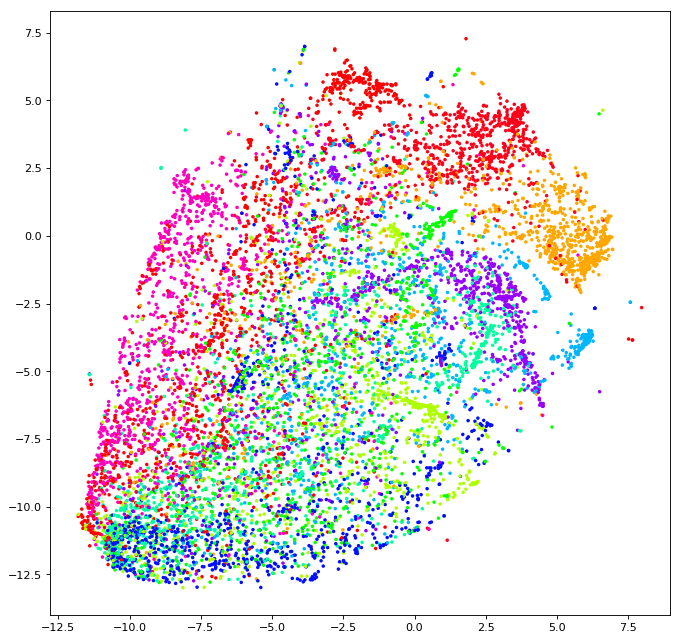

In [18]:
X_embedded = plot_tsne(features)

## Conclusion
The following are the accuracies on 1000 samples of validation data:<br>
InceptionV3                    : 80% <br>
Xception                       : 84% <br>
Concatenation of both features : 85% <br>